# Main Analyses

## [1. Build a Recommender System Using Model-Based Collaborative Filtering](#I.-Build-a-Recommender-System-Using-Model-Based-Collaborative-Filtering)
I build recommendation engine using 3 model-based methodologies - Singular Vector Dceomposition ("SVD"), Alternating Least Squares ("ALS"), and neural networks.

[Go To Example Demo](#Step-5.-Example-Recommendations-for-a-User)

## [2. Classify Products Based on Product Images](#II.-Classify-Products-Based-on-Product-Images)
I show how product search can be enhanced by identifying similar groups of products by using sellers' product keywords. Multi-label classifcation neural networks are employed.

[Go To Example Demo](#Step-3.-Example-Product-Classification)

## [3. Extract Key Review Sentences from 1-Star and 5-Star Reviews](#III.-Extract-Key-Review-Sentences-from-1-Star-and-5-Star-Reviews)
I extract featured review sentences that capture common themes of reviews for a product through Term Frequency - Inverse Document Frequency ("TF-IDF").

[Go To Example Demo](#Step-3.-Example-Featured-Review-Sentences)

In [1]:
import pandas as pd
import json
import numpy as np
import re
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.layers import dot
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score, hamming_loss
import names
import string
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import FreqDist

pd.set_option('display.max_colwidth', None)

## I. Build a Recommender System Using Model-Based Collaborative Filtering

In this task, I build a recommender system using 3 model-based collaborative filtering methods:
1. Singular Vector Decomposition ("SVD")
2. Alternating Least Squares ("ALS")
3. Neural Network

Model-based matrix factorization separates a rating into a user component and an item component. An item component has factors related to an item, and a user component has sensitivities to those factors. See the diagram below.



### Step 1. Import & Split into Train/Test Data

In [2]:
reviews = pd.read_csv('Data/Data Used for Analysis/Cleaned Reviews for Pet Supplies.csv', index_col = 0)

df_train, df_test = train_test_split(reviews, stratify = reviews[['userIdNumeric']], test_size = 0.25, random_state = 888)

print('# of Obs and Fields in Train Data: ', df_train.shape)
print('# of Obs and Fields in Test Data: ', df_test.shape)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# of Obs and Fields in Train Data:  (68189, 28)
# of Obs and Fields in Test Data:  (22730, 28)


Further trim the test data so it only contains products that are in the train data.

In [3]:
df_test = df_test[df_test['itemIdNumeric'].isin(df_train['itemIdNumeric'])]

Re-assign the item labels.

In [4]:
items = df_train['itemId'].unique()

itemid2idx_new = {o: i for i, o in enumerate(items)}
df_train['itemIdNumeric'] = df_train['itemId'].apply(lambda x: itemid2idx_new[x])
df_test['itemIdNumeric'] = df_test['itemId'].apply(lambda x: itemid2idx_new[x])

<ipython-input-4-5502cf466733>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['itemIdNumeric'] = df_train['itemId'].apply(lambda x: itemid2idx_new[x])


Convert the train data into a Surpise dataset.

In [5]:
df_surprise = Dataset.load_from_df(df_train[['userId', 'itemId', 'rating']], Reader())
df_new = df_surprise.build_full_trainset()

## III. Training a SVD Model with Surprise Library

SVD is a commonly used matrix factorization method. The equation is: $$ A = U\Sigma V^T$$ 

where $V$ is a rotation, $𝚺$ a stretching and $U$ another rotation. Also, the entries of $U$ are the principal axis while $𝚺$ are the singular values.

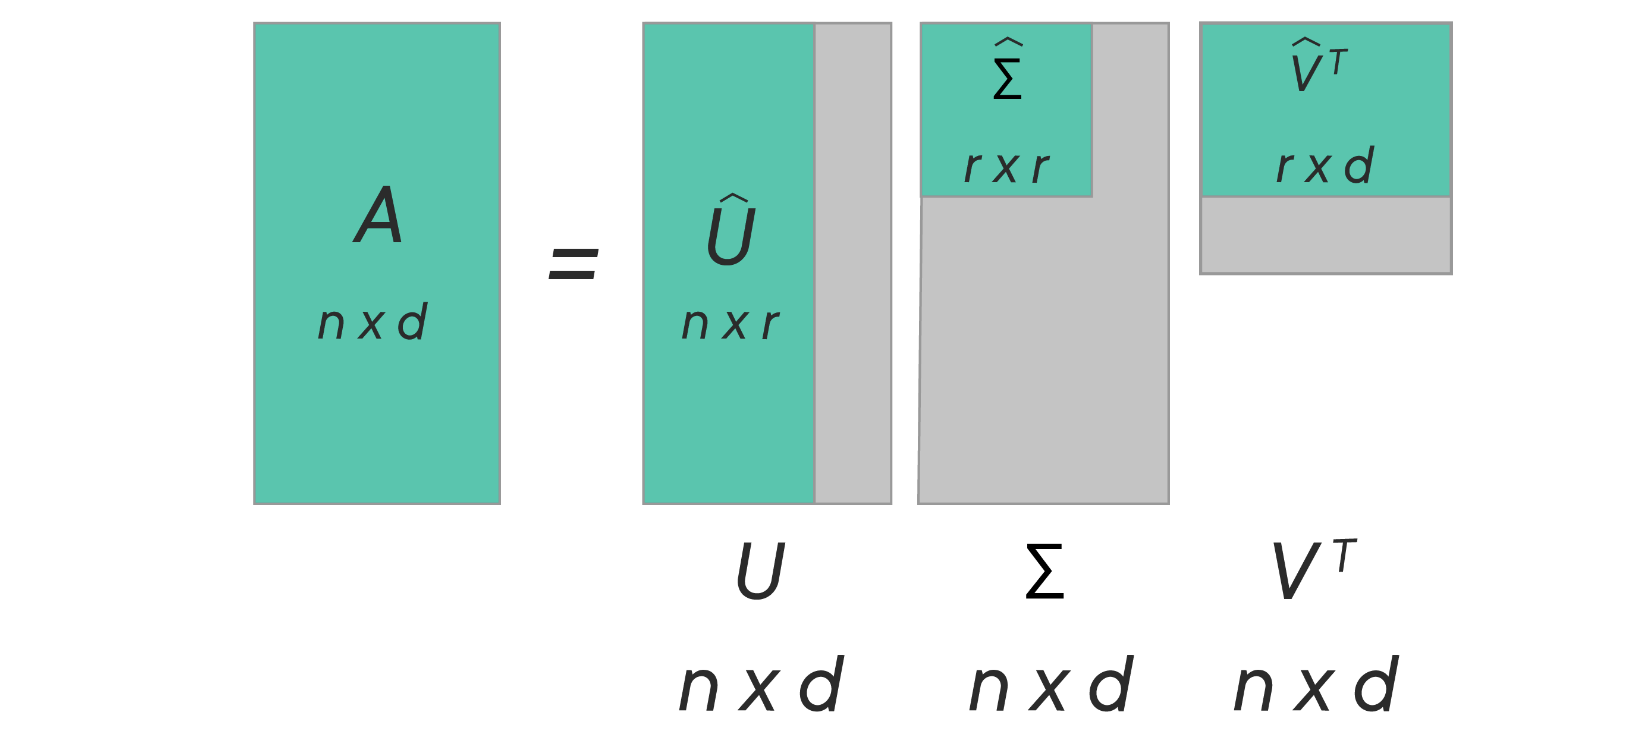

In training the model, I use a package called "surprise" and GridSearchCV to find out best parameters.

Train the SVD model using cross validation.

In [6]:
param_grid = {'n_factors': [20],
              'n_epochs': [5],
              'lr_all': [0.05, 0.1],
              'reg_all': [0.2]}

gs_model = GridSearchCV(SVD, param_grid = param_grid, n_jobs = -1, joblib_verbose = 5, \
                        refit = True, measures = ['rmse', 'mae'])
gs_model.fit(df_surprise)
print('Cross Validation RMSE:', gs_model.best_score['rmse'])
print('Cross Validation MAE:', gs_model.best_score['mae'])
print('')
print('Best Paramaters', '\nfor RMSE:', gs_model.best_params['rmse'], '\nfor MAE:', gs_model.best_params['mae'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    1.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


Cross Validation RMSE: 1.0743833299442744
Cross Validation MAE: 0.7886842803183199

Best Paramaters 
for RMSE: {'n_factors': 20, 'n_epochs': 5, 'lr_all': 0.05, 'reg_all': 0.2} 
for MAE: {'n_factors': 20, 'n_epochs': 5, 'lr_all': 0.05, 'reg_all': 0.2}


Next, I output RMSE, MAE, and overlaps between actual ratings and predictions.

In [7]:
def validation_score(var, varname):
    """
    1) Calculate RMSE, MAE, and overlaps between actual ratings and predictions. 
    2) Also plot the ratings and predictions.
    
    Args:
        var (variable): Prediction variable
        varname (string): New variable name for the prediction variable
        
    Returns:
        float: RMSE
        float: MAE
        int: # of actual 5-star ratings
        int: # of predicted 5-star ratings
        int: # of actual 5-Star ratings, also predicted as 5-Star
        plot: Actual ratings and predicted ratings for all items and users
        
    """
    df_test[varname] = var
    df_test[varname + 'Rounded'] = round(np.maximum(np.minimum(df_test[varname], 5), 1))

    print('Test RMSE:', np.sqrt(((df_test['rating'] - df_test[varname + 'Rounded']) ** 2).mean())) 
    print('Test MAE:', (df_test['rating'] - df_test[varname + 'Rounded']).abs().mean())
    print('')
    print('# of actual 5-stars:', len(df_test[(df_test['rating'] >= 5)]))
    print('# of test ratings predicted as 5-stars:', len(df_test[(df_test[varname + 'Rounded'] >= 5)]))
    print('# of actual 5-stars also predicted as 5-stars:', \
    len(df_test[(df_test['rating'] >= 5) & (df_test[varname + 'Rounded'] >= 5)]))
    
    fig, ax = plt.subplots(figsize = (15, 5))
    df_test.sort_values(['rating', varname + 'Rounded'], inplace = True)
    ax.plot(range(len(df_test)), df_test['rating'], color = 'red', label = 'Actual Ratings')
    ax.scatter(range(len(df_test)), df_test[varname + 'Rounded'], color = 'blue', label = 'Predictions')
    ax.legend();

Test RMSE: 1.1095707494496736
Test MAE: 0.7511615439599714

# of actual 5-stars: 14380
# of test ratings predicted as 5-stars: 8476
# of actual 5-stars also predicted as 5-stars: 6807


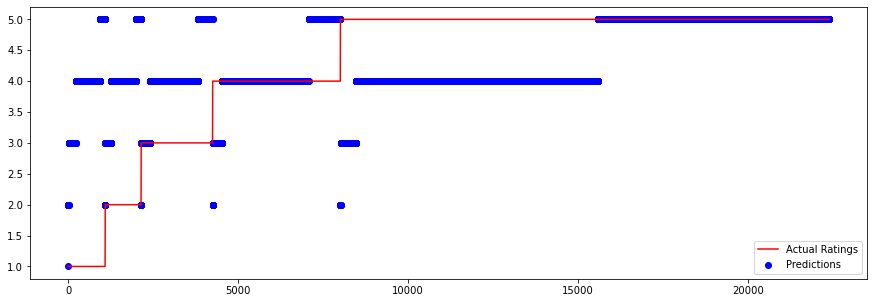

In [8]:
# Predict ratings for all items
test_svd = []
for uid, iid in zip(df_test['userId'], df_test['itemId']):
    try:
        test_svd.append(gs_model.predict(uid, iid)[3])
    except:
        test_svd.append(np.nan)

# Calculate test scores & plot actual vs predicted ratings
validation_score(test_svd, 'predSVD')

### Step 3. Training an ALS Model

ALS minimizes errors by alternating between holding the user embedding matrix constant and the item embedding matrix constant. Below is a decomposition of a rating: a global average, a item bias, a user bias, and a user component, and an item component.

### $$ \hat{r}_{ui} = \mu + b_{i} + b_{u} + q_{i}^{T}p_{u} $$

and the overall loss function becomes:

### $$ L = \sum_{u,i ∈  \kappa}(r_{u,i}− \mu - b_{u} - b_{i} - p_u^T q_i)^2 + \lambda( ||q_i||^2 + |p_u||^2 + b_{u}^{2} + b_{i}^{2})$$

In training the model, I use 20 user latent factors and 20 item latent factors, including the price variable.

In [9]:
# Introduce 20 factors
n_factors = 20
n_users = len(df_train['userId'].unique())
n_items = len(df_train['itemId'].unique())

# Initialize weights and bias for the item embedding matrix
weights_items_initial = pd.DataFrame(np.random.randn(n_items, n_factors + 1) * np.sqrt(2 / n_factors), 
                                      columns = ['item_factor_' + str(i) for i in range(1, n_factors + 1)] + \
                                      ['item_factor_intercept'])
weights_items = weights_items_initial[['item_factor_' + str(i) for i in range(1, n_factors + 1)] + \
                                        ['item_factor_intercept']]
weights_items['itemId'] = df_train['itemId'].unique()

# Merge in the initialized item weights
df0 = df_train.merge(weights_items, how = 'left', on = 'itemId')
df0['item_factor_20'] = (df0['price'] - df0['price'].mean()) / df0['price'].std()

# Initialize weights and bias for the user embedding matrix
for user_factor in ['user_factor_' + str(i) for i in range(1, n_factors + 1)] + ['user_factor_intercept']:
    df0[user_factor] = 0

I train the model for 5 epochs as running it multiple times did not make a meaningful difference.

In [10]:
# Initialize bias for the movies and users
mu = df0['rating'].mean()

# Subtract it from all ratings to get intermediate ratings
df0['rating_int'] = df0['rating'] - mu

# Specify the number of epoches
for i in range(5):
    print('Epoch {} ============================================================================='.format(i + 1))
    
    # Derive a user embedding matrix using Ridge rigression (includes user bias)
    ridge = {}
    counter = 0
    counter_tot = len(df0['userId'].unique())
    for userid in df0['userId'].unique():
        ridge[userid] = Ridge(10)
        df_user = df0[df0['userId'] == userid]
        ridge[userid].fit(df_user[['item_factor_' + str(i) for i in range(1, n_factors + 1)]], df_user['rating_int'])
        if (counter + 1) % 500 == 0 or counter + 1 == len(df0['userId'].unique()):
            print('{0} Users Analyzed ({1:.0f}% Complete)'.format(counter + 1, (counter + 1) * 100 / counter_tot))
        counter += 1
    
    # Combine the individual embedding matrices
    weights_users = pd.concat([pd.Series(np.append(ridge[key].coef_, [ridge[key].intercept_, key])) \
                               for key in ridge.keys()], axis = 1).transpose()
    weights_users.columns = ['user_factor_' + str(i) for i in range(1, n_factors + 1)] + \
    ['user_factor_intercept', 'userId']
    
    # Merge to the main dataset and subtract user bias from all ratings to get intermediate ratings
    df0 = df0.drop(['user_factor_' + str(i) for i in range(1, n_factors + 1)] + \
                   ['user_factor_intercept'], axis = 1).\
                    merge(weights_users, left_on = 'userId', right_on = 'userId')
    for user_factor in ['user_factor_' + str(i) for i in range(1, n_factors + 1)] + ['user_factor_intercept']:
        df0[user_factor] = df0[user_factor].apply(lambda x: float(x))
    df0['rating_int'] = df0['rating'] - mu - df0['user_factor_intercept']
    
    # Derive a item embedding matrix using Ridge regression (includes item bias)
    ridge_item = {}
    counter = 0
    counter_tot = len(df0['itemId'].unique())
    print('')
    for itemid in df0['itemId'].unique():
        ridge_item[itemid] = Ridge(5)
        df_item = df0[df0['itemId'] == itemid]
        ridge_item[itemid].fit(df_item[['user_factor_' + str(i) for i in range(1, n_factors)]], df_item['rating_int'])
        if (counter + 1) % 500 == 0 or counter + 1 == len(df0['itemId'].unique()):
            print('{0} Items Analyzed ({1:.0f}% Complete)'.format(counter + 1, (counter + 1) * 100 / counter_tot))
        counter += 1

    weights_movies = pd.concat([pd.Series(np.append(ridge_item[key].coef_, [ridge_item[key].intercept_, key]))\
                                for key in ridge_item.keys()], axis = 1).transpose()
    weights_movies.columns = ['item_factor_' + str(i) for i in range(1, n_factors)] + \
    ['item_factor_intercept', 'itemId']
    
    df0 = df0.drop(['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept'], axis = 1).\
    merge(weights_movies, on = 'itemId')
    for movie_factor in ['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept']:
        df0[movie_factor] = df0[movie_factor].apply(lambda x: float(x))
    df0['rating_int'] = df0['rating'] - mu - df0['item_factor_intercept']
    print('')
    
    # Global average
    # Combine the individual embedding matrices
    weights_items = pd.concat([pd.Series(np.append(ridge_item[key].coef_, [ridge_item[key].intercept_, key]))\
                                for key in ridge_item.keys()], axis = 1).transpose()
    weights_items.columns = ['item_factor_' + str(i) for i in range(1, n_factors)] + \
    ['item_factor_intercept', 'itemId']
    
    # Merge to the main dataset and subtract item bias from all ratings to get intermediate ratings
    df0 = df0.drop(['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept'], axis = 1).\
    merge(weights_items, on = 'itemId')
    for item_factor in ['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept']:
        df0[item_factor] = df0[item_factor].apply(lambda x: float(x))
    df0['rating_int'] = df0['rating'] - mu - df0['item_factor_intercept']
    print('')
    
    # Re-calculate global average
    mu = (df0['rating'] - (df0['user_factor_intercept'] + df0['item_factor_intercept'] + \
          df0['user_factor_1'] * df0['item_factor_1'] + df0['user_factor_2'] * df0['item_factor_2'] + \
          df0['user_factor_3'] * df0['item_factor_3'] + df0['user_factor_4'] * df0['item_factor_4'] + \
          df0['user_factor_5'] * df0['item_factor_5'] + df0['user_factor_6'] * df0['item_factor_6'] + \
          df0['user_factor_7'] * df0['item_factor_7'] + df0['user_factor_8'] * df0['item_factor_8'] + \
          df0['user_factor_9'] * df0['item_factor_9'] + df0['user_factor_10'] * df0['item_factor_10'] + \
          df0['user_factor_11'] * df0['item_factor_11'] + df0['user_factor_12'] * df0['item_factor_12'] + \
          df0['user_factor_13'] * df0['item_factor_13'] + df0['user_factor_14'] * df0['item_factor_14'] + \
          df0['user_factor_15'] * df0['item_factor_15'] + df0['user_factor_16'] * df0['item_factor_16'] + \
          df0['user_factor_17'] * df0['item_factor_17'] + df0['user_factor_18'] * df0['item_factor_18'] + \
          df0['user_factor_19'] * df0['item_factor_19'] + df0['user_factor_20'] * df0['item_factor_20'])).\
    mean()

Epoch 1 =============================================================================
500 Users Analyzed (15% Complete)
1000 Users Analyzed (30% Complete)
1500 Users Analyzed (46% Complete)
2000 Users Analyzed (61% Complete)
2500 Users Analyzed (76% Complete)
3000 Users Analyzed (91% Complete)
3284 Users Analyzed (100% Complete)

500 Items Analyzed (7% Complete)
1000 Items Analyzed (13% Complete)
1500 Items Analyzed (20% Complete)
2000 Items Analyzed (26% Complete)
2500 Items Analyzed (33% Complete)
3000 Items Analyzed (39% Complete)
3500 Items Analyzed (46% Complete)
4000 Items Analyzed (52% Complete)
4500 Items Analyzed (59% Complete)
5000 Items Analyzed (65% Complete)
5500 Items Analyzed (72% Complete)
6000 Items Analyzed (78% Complete)
6500 Items Analyzed (85% Complete)
7000 Items Analyzed (91% Complete)
7500 Items Analyzed (98% Complete)
7685 Items Analyzed (100% Complete)


Epoch 2 =============================================================================
500 Users Analyzed (1

In [11]:
# Calculate train data scores

def predict_als(data):
    """
    Predict ratings using ALS

    Args:
        data (data): train data or test data
        
    Returns:
        data: train data or test data
        
    """
    df = data.merge(weights_users, on = 'userId').merge(weights_items, on = 'itemId')

    for user_factor in ['user_factor_' + str(i) for i in range(1, n_factors + 1)] + ['user_factor_intercept']:
        df[user_factor] = df[user_factor].apply(lambda x: float(x))

    for item_factor in ['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept']:
        df[item_factor] = df[item_factor].apply(lambda x: float(x))

    df['item_factor_20'] = (df['price'] - df['price'].mean()) / df['price'].std()

    df['predALS'] = mu + df['user_factor_intercept'] + df['item_factor_intercept'] + \
    df['user_factor_1'] * df['item_factor_1'] + df['user_factor_2'] * df['item_factor_2'] + \
    df['user_factor_3'] * df['item_factor_3'] + df['user_factor_4'] * df['item_factor_4'] + \
    df['user_factor_5'] * df['item_factor_5'] + df['user_factor_6'] * df['item_factor_6'] + \
    df['user_factor_7'] * df['item_factor_7'] + df['user_factor_8'] * df['item_factor_8'] + \
    df['user_factor_9'] * df['item_factor_9'] + df['user_factor_10'] * df['item_factor_10'] + \
    df['user_factor_11'] * df['item_factor_11'] + df['user_factor_12'] * df['item_factor_12'] + \
    df['user_factor_13'] * df['item_factor_13'] + df['user_factor_14'] * df['item_factor_14'] + \
    df['user_factor_15'] * df['item_factor_15'] + df['user_factor_16'] * df['item_factor_16'] + \
    df['user_factor_17'] * df['item_factor_17'] + df['user_factor_18'] * df['item_factor_18'] + \
    df['user_factor_19'] * df['item_factor_19'] + df['user_factor_20'] * df['item_factor_20']

    df['predALSRounded'] = round(np.maximum(np.minimum(df['predALS'], 5), 1), 0)
    
    return df
    
df0 = predict_als(df_train)
print('Train RMSE:', np.sqrt(((df0['rating'] - df0['predALSRounded']) ** 2).mean())) 
print('Train MAE:', (df0['rating'] - df0['predALSRounded']).abs().mean())

Train RMSE: 0.8097573292061896
Train MAE: 0.49292407866371407


Test RMSE: 1.1449222827753092
Test MAE: 0.7583988563259471

# of actual 5-stars: 14380
# of test ratings predicted as 5-stars: 9481
# of actual 5-stars also predicted as 5-stars: 7492


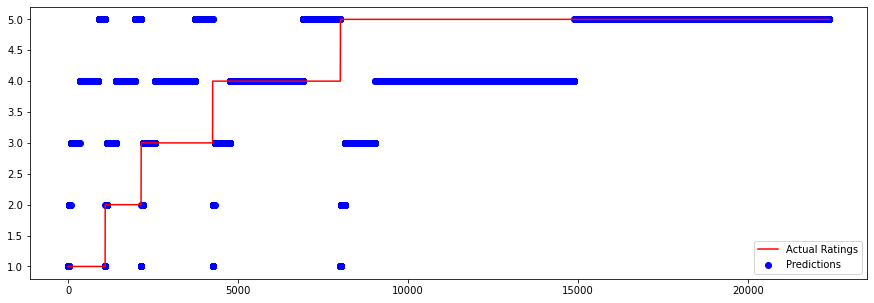

In [12]:
# Calculate test scores & plot actual vs predicted ratings

df1 = predict_als(df_test)
df1 = df1.sort_values(['itemId', 'userId']).reset_index()
df_test = df_test.sort_values(['itemId', 'userId']).reset_index()
validation_score(df1['predALS'], 'predALS')

### Step 4. Training a Neural Network Model

Using a neural network for recommender system implementation entails creating a user embedding matrix and an item embedding matrix and putting a dot product of them into the neural network.

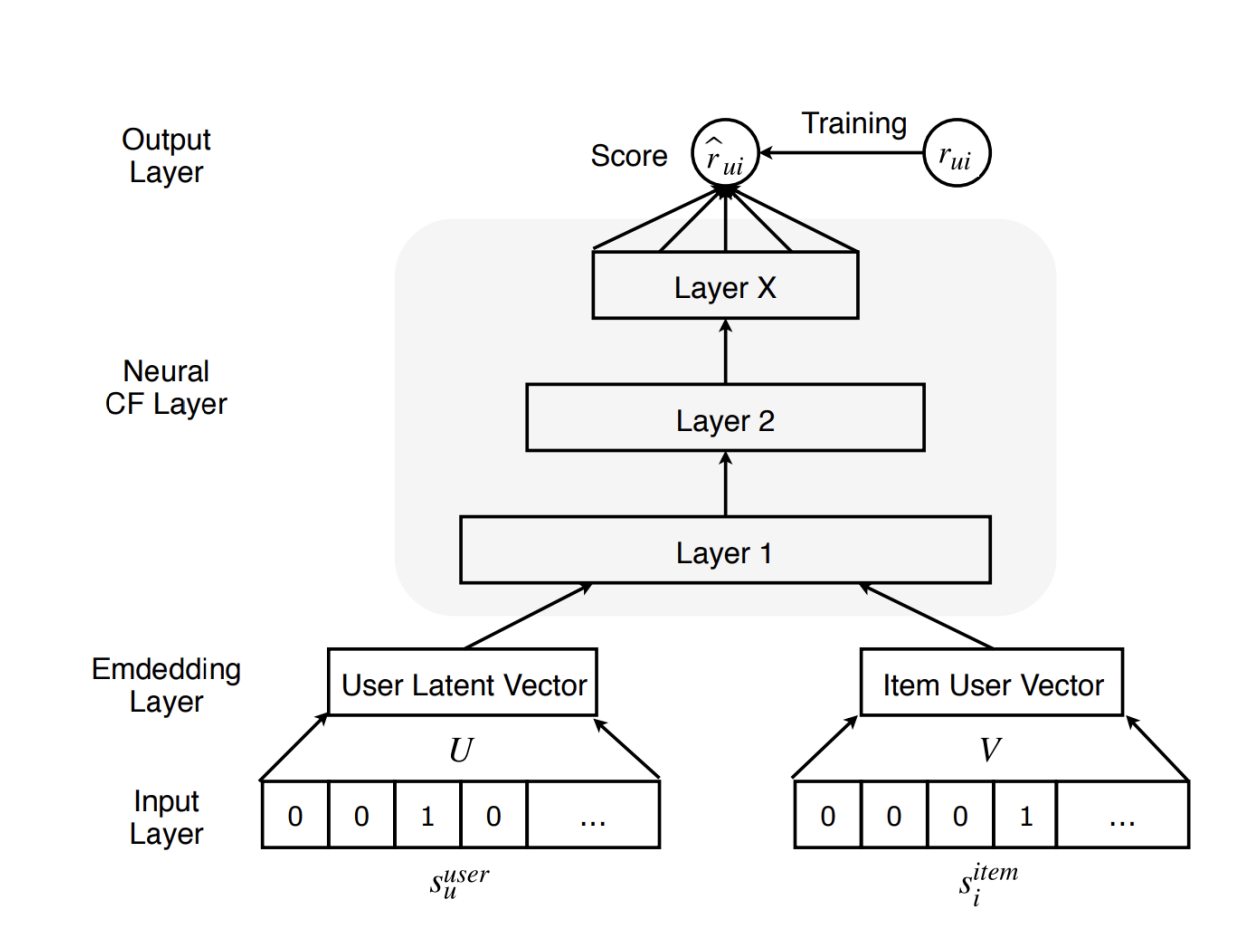

Introduce a neural network with 50 latent factors for users and items, 2 hidden layers, and a dropout rate of 0.4.

In [13]:
n_users = len(df_train['userIdNumeric'].unique())
n_items = len(df_train['itemIdNumeric'].unique())

# Establish a user embedding matrix
user_input = Input(shape = (1, ), name = 'user_input', dtype = 'int64')
user_embedding = Embedding(n_users, 50, name = 'user_embedding', 
                           embeddings_initializer = tf.keras.initializers.GlorotUniform(seed = 42))(user_input)
user_vec = Flatten(name = 'FlattenUsers')(user_embedding)
user_vec = Dropout(0.4)(user_vec)

# Establish a item embedding matrix
item_input = Input(shape = (1, ), name = 'item_input', dtype = 'int64')
item_embedding = Embedding(n_items, 50, name = 'item_embedding', 
                           embeddings_initializer = tf.keras.initializers.GlorotUniform(seed = 42))(item_input)
item_vec = Flatten(name = 'FlattenItems')(item_embedding)
item_vec = Dropout(0.4)(item_vec)

sim = dot([user_vec, item_vec], name = 'Similarity-Dot-Product', axes = 1)

# Establish two hidden layers
nn_inp = Dense(256, activation = 'relu')(sim)
nn_inp = Dropout(0.4)(nn_inp)
nn_inp = Dense(128, activation = 'relu')(nn_inp)
nn_inp = BatchNormalization()(nn_inp)
nn_inp = Dense(1)(nn_inp)

nn_model = Model([user_input, item_input], nn_inp)

Below is the model structure.

In [14]:
nn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        164200      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 50)        384250      item_input[0][0]                 
_______________________________________________________________________________________

Train the model for 20 epochs.

In [15]:
nn_model.compile(optimizer = Adam(lr = 1e-4), loss = ['mse'], metrics = ['mae'])
batch_size = 128
history = nn_model.fit([df_train['userIdNumeric'], df_train['itemIdNumeric']], df_train['rating'], 
                       batch_size = batch_size, epochs = 5, 
                       validation_data = ([df_test['userIdNumeric'], df_test['itemIdNumeric']], df_test['rating']),
                       verbose = 1)

Epoch 1/5
533/533 [==============================] - 3s 5ms/step - loss: 14.9956 - mae: 3.6854 - val_loss: 9.5476 - val_mae: 2.9194
Epoch 2/5
533/533 [==============================] - 2s 4ms/step - loss: 5.1702 - mae: 2.0859 - val_loss: 2.2746 - val_mae: 1.4080
Epoch 3/5
533/533 [==============================] - 3s 5ms/step - loss: 1.5480 - mae: 1.0865 - val_loss: 1.2894 - val_mae: 0.9303
Epoch 4/5
533/533 [==============================] - 3s 5ms/step - loss: 1.2206 - mae: 0.8614 - val_loss: 1.2803 - val_mae: 0.8925
Epoch 5/5
533/533 [==============================] - 3s 6ms/step - loss: 1.1229 - mae: 0.7906 - val_loss: 1.3204 - val_mae: 0.8784


Test RMSE: 1.210066190688358
Test MAE: 0.8850964974982131

# of actual 5-stars: 14380
# of test ratings predicted as 5-stars: 6567
# of actual 5-stars also predicted as 5-stars: 4305


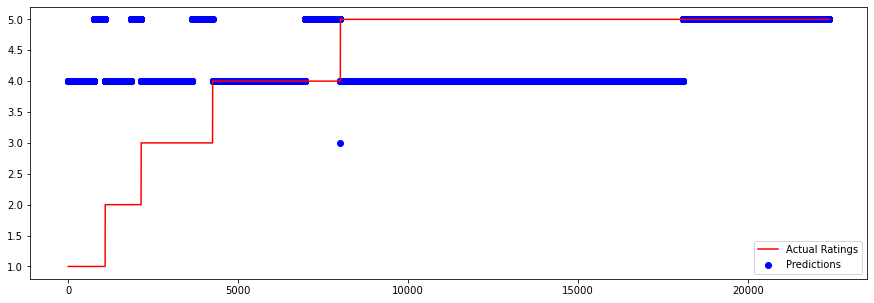

In [16]:
# Calculate test scores & plot actual vs predicted ratings

validation_score(nn_model.predict([df_test['userIdNumeric'], df_test['itemIdNumeric']]), 'predNeural')

### Step 5. Example Recommendations for a User

I will see how reasonable recommendations are for an example user in the train data. Below shows the first five product ratings for different users.

In [17]:
df_train.head()

itemId          userId  rating         time  \
2308395  B003BYQ100  A13TUDSG4QK0P0     5.0  01 20, 2014   
5757574  B01G36IPH4  A1SL6UNM4QJJLS     2.0   10 5, 2016   
1052460  B000FULD24  A1NTOCQSX1KQO2     5.0  08 16, 2016   
5246065  B015WD6W0Q  A1IZJVLNMFACS6     4.0   03 6, 2017   
4086087  B00IMJ6JCO   AJEHZUCVJHA2Z     4.0   11 2, 2015   

                                                                summary vote  \
2308395                                               Armarkat Cat Tree  NaN   
5757574                                              Not for small dogs  NaN   
1052460                                         Dogs said it taste good   16   
5246065  Grain free, and healthy, but our cats said paws down..........  NaN   
4086087                                                     worked good  NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviewText  \
2308395                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I love it and so does my cat.  Very sturdy well made tree.  Relatively easy to assemble; perches and house are a good size.  Love the fleece - does not shed like the faux fur trees and is softer and more comfortable, too.  Also like the rims on the upper perches.  Priced very reasonably.  The quality of this tree can't be beat for the price!   
5757574                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Among them, I pick User ID 'A1SL6UNM4QJJLS' as an example. Note that I only recommend items that have at least 30 reviews.

In [18]:
# Get a list of items with at least 30 reviews
item_count = df_train.groupby('itemId')['itemId'].count().sort_values()
items_to_use = item_count[item_count >= 30]

# Get weights for all products for the user
example_weights_users = weights_users[weights_users['userId'] == 'A1SL6UNM4QJJLS']
example_weights_users['temp_key'] = 1
examples_weights_items = weights_items[weights_items['itemId'].isin(items_to_use.index)]
examples_weights_items['temp_key'] = 1

example_matrix = example_weights_users.merge(examples_weights_items, on = 'temp_key')

for user_factor in ['user_factor_' + str(i) for i in range(1, n_factors + 1)] + ['user_factor_intercept']:
    example_matrix[user_factor] = example_matrix[user_factor].apply(lambda x: float(x))
    
for item_factor in ['item_factor_' + str(i) for i in range(1, n_factors)] + ['item_factor_intercept']:
    example_matrix[item_factor] = example_matrix[item_factor].apply(lambda x: float(x))

# Get prices for each item    
example_matrix = example_matrix.merge(df_train[['itemId', 'title', 'price']].drop_duplicates(), on = 'itemId')
example_matrix = example_matrix.merge(df_train[['itemId', 'title', 'price']], on = 'itemId').drop_duplicates()

<ipython-input-18-cc0d58f0ee37>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_weights_users['temp_key'] = 1
<ipython-input-18-cc0d58f0ee37>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  examples_weights_items['temp_key'] = 1


In [19]:
# Get prices for each item    
example_matrix = example_matrix.merge(df_train[['itemId', 'title', 'price']].drop_duplicates(), on = 'itemId')
example_matrix['item_factor_20'] = (example_matrix['price'] - example_matrix['price'].mean()) / example_matrix['price'].std()

# Predict ratings for the user
example_matrix['predALS'] = mu + example_matrix['user_factor_intercept'] + example_matrix['item_factor_intercept'] + \
example_matrix['user_factor_1'] * example_matrix['item_factor_1'] + example_matrix['user_factor_2'] * example_matrix['item_factor_2'] + \
example_matrix['user_factor_3'] * example_matrix['item_factor_3'] + example_matrix['user_factor_4'] * example_matrix['item_factor_4'] + \
example_matrix['user_factor_5'] * example_matrix['item_factor_5'] + example_matrix['user_factor_6'] * example_matrix['item_factor_6'] + \
example_matrix['user_factor_7'] * example_matrix['item_factor_7'] + example_matrix['user_factor_8'] * example_matrix['item_factor_8'] + \
example_matrix['user_factor_9'] * example_matrix['item_factor_9'] + example_matrix['user_factor_10'] * example_matrix['item_factor_10'] + \
example_matrix['user_factor_11'] * example_matrix['item_factor_11'] + example_matrix['user_factor_12'] * example_matrix['item_factor_12'] + \
example_matrix['user_factor_13'] * example_matrix['item_factor_13'] + example_matrix['user_factor_14'] * example_matrix['item_factor_14'] + \
example_matrix['user_factor_15'] * example_matrix['item_factor_15'] + example_matrix['user_factor_16'] * example_matrix['item_factor_16'] + \
example_matrix['user_factor_17'] * example_matrix['item_factor_17'] + example_matrix['user_factor_18'] * example_matrix['item_factor_18'] + \
example_matrix['user_factor_19'] * example_matrix['item_factor_19'] + example_matrix['user_factor_20'] * example_matrix['item_factor_20']

Below are the ratings the user 'A1SL6UNM4QJJLS' made.

In [20]:
df_train[df_train['userId'] == 'A1SL6UNM4QJJLS'][['itemId', 'title', 'price', 'rating']]

,itemId,title,price,rating
5757574,B01G36IPH4,"Zacro Dog Doorbells for Dog Training and Housebreaking Your Doggy and 1 Training Clicker DB021 Doorbells, Adjustable Door Bell Length, 7 Count",7.99,2.0
2108794,B0027J5RZA,Nylabone Dental Chew Bacon flavored Pro Action Bone Dog Chew Toy,12.29,1.0
670850,B000634L3I,De Flea Pet and Bedding Spray for Dogs,9.85,5.0
2374312,B003P9XG3G,Blue Health Bars Crunchy Dog Treats,12.73,5.0
5153506,B01407L7WI,"Natural Pet Spray for Dogs and Cats with Lavender &amp; Evening Primrose &ndash; Eliminates Odor - Use for Daily Grooming, Pet Aromatherapy &amp; Odor Control - 8 Oz Bottle - USA Made By Honeydew Products",11.95,3.0
3331526,B009MLYSKQ,Everlasting Treat Chicken Usa,8.48,5.0
4016059,B00HTRW3N4,"ShoppingLion Pet Waste Bags, Dog Waste &amp; Poop Bags, EPI Technology, Dispenser &amp; Clip Included",23.45,4.0
469864,B0002DJY3Y,"Fashion Pet Classic Cable Dog Sweater, Pink",10.37,5.0
3054381,B006YFZBS6,Nylabone Advanced Oral Care Dental Spray for Dogs,8.29,5.0
4151802,B00JGSM0VE,Nature's Miracle Deodorizing Honey Sage Wipes,8.49,1.0


Based on the ratings, the recommender system outputs the 10 recommendations.

In [21]:
example_matrix.nlargest(10, 'predALS')[['itemId', 'title', 'price', 'item_factor_intercept', 'predALS']]

,itemId,title,price,item_factor_intercept,predALS
204,B0007A0AQW,Zuke's Mini Naturals Dog Treats,5.27,0.307694,4.391878
234,B00025K0R6,Petrodex Enzymatic Toothpaste Dog Poultry Flavor,5.57,0.074341,4.217101
393,B000255MZG,API STRESS COAT Aquarium Water Conditioner,6.31,0.346842,4.174374
211,B000F4AVPA,Chuckit! Ultra Ball,7.80,0.518178,4.153462
367,B000255PFI,Seachem Prime,4.19,0.586226,4.123604
58,B00BJLS55G,"Stainless Steel Pet Id Tags, Personalized Dog Tags &amp; Cat Tags. Up to 8 Lines of Text &ndash; Engraved Front &amp; Back. Bone, Round, Heart, Flower, Shield, House, Star, Rectangle, Bow Tie.",7.95,0.541995,4.120108
152,B0002565TI,Marineland Rite-Size Penguin Power Filter Cartridges,4.99,0.198484,4.087380
132,B0002AS1CC,Bergan Turbo Scratcher Accessories,5.05,0.511754,4.080185
7,B00M0FK8V4,Temptations Mixup Treats For Cats 16 Ounces,7.98,0.400825,4.074519
11,B0002DHXX2,MidWest Deluxe Bolster Pet Bed for Dogs &amp; Cats,47.35,0.086764,4.068496


## II. Classify Products Based on Product Images

In this taks, I predict categories for a product based on its image and keywords that sellers input for their products. I use a neural network for training. Note that there are often more than one category assigned to a product.

### Step 1. Import & Split into Train/Test Data¶

In [22]:
# Import target labels
labels = pd.read_csv('Data/Data Used for Analysis/Cleaned Labels for Shoes.csv', index_col = 0)

# Split labels into train/test labels
labels_train, labels_test = train_test_split(labels, test_size = 0.25, random_state = 888)

print('# of Obs and Fields in Train Data: ', labels_train.shape)
print('# of Obs and Fields in Test Data: ', labels_test.shape)

# of Obs and Fields in Train Data:  (1846, 1095)
# of Obs and Fields in Test Data:  (616, 1095)


In [23]:
# Import images
images = pd.read_pickle('Data/Data Used for Analysis/Cleaned Images.pickle')

# Split images into train/test images
images_train = tf.convert_to_tensor([images[i] for i in labels_train.index])
images_test = tf.convert_to_tensor([images[i] for i in labels_test.index])

I am only using common labels that show up for more than 30 products.

In [24]:
labels_used = labels_train.iloc[:, 4:].columns[labels_train.iloc[:, 4:].sum() > 30]
labels_used

Index(['amazon', 'black', 'casual', 'casual shoe', 'casual shoes',
       'casual shoes for men', 'casual shoes for mens',
       'casual shoes for mens stylish', 'chappals for men latest',
       'designer cocktail work wear office sexy spring fall gifts for her',
       'fathers day gifts for dad', 'flats for womens casual',
       'flip flops for mens', 'footwear', 'footwear for women stylish',
       'formal shoes for men black', 'formal shoes for mens leather', 'gents',
       'girls shoes', 'heels for women', 'heels for women stylish',
       'ladies shoes', 'leather shoes for men formal branded',
       'leather shoes for mens', 'loafers', 'loafers for mens stylish latest',
       'lofar shoes for mens', 'men casual shoe', 'men casual shoes',
       'men shoes', 'men shoes casual shoes', 'men shoes casual wear',
       'men sneakers', 'men sneakers shoes', 'men's shoes casual',
       'mens casual shoe', 'mens casual shoes', 'mens sandals', 'mens shoes',
       'mens shoes casua

Subset to the common labels for train/test data and also convert NULLs into zeros.

In [25]:
labels_train = labels_train.loc[:, ['image_id', 'height', 'width', 'path'] + list(labels_used)].fillna(0)
labels_test = labels_test.loc[:, ['image_id', 'height', 'width', 'path'] + list(labels_used)].fillna(0)

### Step 2A. Train a Neural Network

I train a convolutional neural network to predict sub-categories for products. I create 4 hidden layers and train the model for 100 epochs.

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (64, 64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (4, 4), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(len(labels_used), activation = 'sigmoid'))

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = "Adam",
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [27]:
history = model.fit(x = images_train,
                    y = labels_train.iloc[:, 4:],
                    epochs = 20,
                    batch_size = 32)

Epoch 1/20
58/58 [==============================] - 6s 99ms/step - loss: 0.2837 - binary_accuracy: 0.8954
Epoch 2/20
58/58 [==============================] - 5s 91ms/step - loss: 0.2095 - binary_accuracy: 0.9337
Epoch 3/20
58/58 [==============================] - 5s 92ms/step - loss: 0.1827 - binary_accuracy: 0.9406
Epoch 4/20
58/58 [==============================] - 5s 89ms/step - loss: 0.1566 - binary_accuracy: 0.9448
Epoch 5/20
58/58 [==============================] - 5s 90ms/step - loss: 0.1380 - binary_accuracy: 0.9499
Epoch 6/20
58/58 [==============================] - 6s 97ms/step - loss: 0.1234 - binary_accuracy: 0.9542
Epoch 7/20
58/58 [==============================] - 6s 108ms/step - loss: 0.1106 - binary_accuracy: 0.9587
Epoch 8/20
58/58 [==============================] - 6s 96ms/step - loss: 0.1041 - binary_accuracy: 0.9596
Epoch 9/20
58/58 [==============================] - 6s 95ms/step - loss: 0.0892 - binary_accuracy: 0.9655
Epoch 10/20
58/58 [==========================

The training binary accuracy is 0.99.

In [28]:
yhat = model.predict(images_train).round(0)
1 - hamming_loss(labels_train.iloc[:, 4:], yhat)

0.9904478150957025

Below are three examples showing the actual labels and predicted labels.  Note that they do not necessarily need to be exactly the same as long as the predicted lables make sense.

In [29]:
def labels_actual_pred(labels, i):
    """
    Compare actual labels vs predicted labels

    Args:
        data (data): train data or test data
        index (int): example number
        
    Returns:
        data: actual labels and predicted labels
        image: product image
        
    """
    actual = labels.iloc[i, 4:]
    pred = pd.DataFrame([yhat[i]], columns = actual.index)
    comparison = pd.concat([actual, pred.transpose()], axis = 1)
    comparison.columns = ['Actual', 'Predicted']
    print(comparison[(comparison['Actual'] == 1) | (comparison['Predicted'] == 1)])

Example #1

                            Actual  Predicted
footwear for women stylish       1        1.0
heels for women                  1        1.0
heels for women stylish          1        1.0
sandal for women stylish         1        1.0
sandals for girls                1        1.0
sandals for women stylish        1        1.0
wedges for women stylish         1        1.0
women sandals latest design      1        1.0


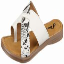

In [30]:
labels_actual_pred(labels_train, 600)
array_to_img(images_train[600])

Example #2

                                     Actual  Predicted
formal shoes for men black                1        1.0
formal shoes for mens leather             1        1.0
leather shoes for men formal branded      1        1.0
leather shoes for mens                    1        1.0
men shoes casual shoes                    1        1.0
mens shoes                                1        1.0
shoes                                     1        1.0
shoes for men                             1        1.0
shoes for men formal                      1        1.0


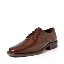

In [31]:
labels_actual_pred(labels_train, 1200)
array_to_img(images_train[1200])

Example #3

                        Actual  Predicted
girls shoes                  1        0.0
ladies shoes                 1        1.0
shoes                        1        0.0
shoes for girls              1        1.0
shoes for women              1        1.0
shoes for women stylish      1        1.0
sneakers for women           1        1.0
sports shoes for women       1        1.0
women shoes for walking      1        1.0


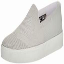

In [32]:
labels_actual_pred(labels_train, 1800)
array_to_img(images_train[1800])

### Step 2B. Validate Using Test Data

The resulting test binary accuracy is 0.96.

In [33]:
yhat = model.predict(images_test).round(0)
1 - hamming_loss(labels_test.iloc[:, 4:], yhat)

0.9625180375180376

Below are three examples showing the actual labels and predicted labels.

Example #1

                                Actual  Predicted
casual shoes for mens                1        1.0
loafers                              1        1.0
loafers for mens stylish latest      1        1.0
lofar shoes for mens                 1        1.0
men shoes casual shoes               1        1.0
mens shoes                           1        1.0
shoes                                1        1.0
shoes for men                        1        1.0
sneakers                             1        1.0
sneakers for mens                    1        1.0
white shoes for mens sneakers        1        1.0


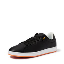

In [34]:
labels_actual_pred(labels_test, 100)
array_to_img(images_train[100])

Example #2

           Actual  Predicted
loafers         1        1.0
mens shoes      1        1.0
shoes           1        1.0


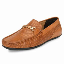

In [35]:
labels_actual_pred(labels_test, 200)
array_to_img(images_train[200])

Example #3

                                Actual  Predicted
casual shoes for mens                1        0.0
formal shoes for men black           0        1.0
loafers                              1        0.0
loafers for mens stylish latest      1        0.0
lofar shoes for mens                 1        0.0
men shoes casual shoes               1        1.0
mens shoes                           1        1.0
shoes                                1        1.0
shoes for men                        1        1.0
sneakers                             1        0.0
sneakers for mens                    1        0.0
white shoes for mens sneakers        1        0.0


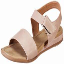

In [36]:
labels_actual_pred(labels_test, 300)
array_to_img(images_train[300])

### Step 3. Example Product Classification

This is a demo for when a user does a search using a word "formal". Resulting related keywords are as follows:

In [37]:
labels_to_search = labels_test.columns[labels_test.columns.str.contains('formal') == 1]
labels_to_search

Index(['formal shoes for men black', 'formal shoes for mens leather',
       'leather shoes for men formal branded', 'shoes for men formal'],
      dtype='object')

Pull products that have lables containing "formal".

In [38]:
examples = labels_test[(labels_test['formal shoes for men black'] == 1) |
                       (labels_test['formal shoes for mens leather'] == 1) |
                       (labels_test['leather shoes for men formal branded'] == 1) |
                       (labels_test['shoes for men formal'] == 1)]

Below are some example products:

Formal Shoes Example #1

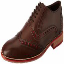

In [39]:
array_to_img(images[examples.index[0]])

Formal Shoes Example #2

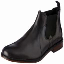

In [40]:
array_to_img(images[examples.index[1]])

Formal Shoes Example #3

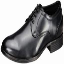

In [41]:
array_to_img(images[examples.index[2]])

## III. Extract Key Review Sentences from 1-Star and 5-Star Reviews

Theh goal of this task is to provide customers with featured key review sentences containing words that are frequently referenced throughout all reviews.  These words should also be the ones uniquely arising in positive reviews of a product that are not appearing in other negative reviews, and vice versa.

The strategy to implement this concept is as follows:

1. To extract featured review sentences from positive reviews of a product, collect all of the positive reviews and get counts for each word showing up in them.
2. Also, collect negative reviews generally from other reviews and get counts for each word.
3. Employ Term Frequency-Inverse Document Frequency ("TF-IDF") for these two sets of word counts to get keywords that are consisently and uniquely appearing in the positive reviews of the product that we are interested in.
4. Finally, pull sentences that contain such keywords from the most popular reviews (identified by the number of votes).

### Step 1. Clean Reviews

I combine all reviews into one string for a product. I also create corpuses for positive reviews and negative reviews which I can utilize later to contrast reviews against.

First, convert the "vote" field to a numeric one. Dedup reviews so we do not double-count the same reviews.

In [42]:
reviews['vote'] = reviews['vote'].str.replace(',', '').fillna(0).apply(lambda x: int(x))
reviews.drop_duplicates('reviewText', inplace = True)

Clean 1-star reviews.

In [43]:
reviews_1 = reviews[(reviews['rating'] <= 1) & (reviews['reviewText'].notnull())]
reviews_1_multiple = reviews_1.groupby('asin')['asin'].count() >= 10
reviews_1_raw = reviews_1[reviews_1['asin'].isin(reviews_1_multiple[reviews_1_multiple == True].index)]

corpus_negative = ' '.join(reviews_1_raw['reviewText'])

Repeat the same process for 5-star ratings.

In [44]:
reviews_5 = reviews[(reviews['rating'] >= 5) & (reviews['reviewText'].notnull())]
reviews_5_multiple = reviews_5.groupby('asin')['asin'].count() >= 10
reviews_5_raw = reviews_5[reviews_5['asin'].isin(reviews_5_multiple[reviews_5_multiple == True].index)]

corpus_positive = ' '.join(reviews_5_raw['reviewText'])

### Step 2. Implement TF-IDF

In this section, I create a class to implement TF-IDF.  The steps are as follows:

1. Derive bags of words for positive reviews of a product and a negative review corpus, using the word_tokenize function from nltk.  Note that I do not include stop words or punctuations in these bags of words.
2. Calculate IDF for all unique words across positive reviews and a negative review corpus.
3. Calculate TF-IDF for words appearing in positive reviews.
4. Extract keywords for the positive reviews and the most popular reviews that contain those keywords.
5. Do this exercise for negative reviews as well.

First, I construct stop words including common names and punctuation.

In [45]:
gist_file = open("Data/Data Used for Analysis/gist_stopwords.txt", "r")

try:
    content = gist_file.read()
    stopwords_list = content.split(",")
finally:
    gist_file.close()
    
names_example = [names.get_first_name().lower() for i in range(10000)]
stopwords_list += list(string.punctuation)
stopwords_list += names_example

Below is a Python class for extracting review sentences.

In [46]:
class tf_idf(object):
    """
    Extract 5 positive & 5 negative review sentences for a product.
    
    Args: 
        Positive reviews (string): All 5-star reviews
        Negative reviews (string): All 1-star reviews
        Product ID (string)
        
    """
    def __init__(self, list_of_reviews_positive, list_of_reviews_negative, num):
        self.list_of_reviews_pos = list_of_reviews_positive
        self.list_of_reviews_neg = list_of_reviews_negative
        self.num = num
    
    def derive_bag_of_words(self):
        """
        Derive bags of words for positive reviews of a product and a negative review corpus, 
        using the word_tokenize function from nltk.
        
        Args:
            Positive reviews (string): All 5-star reviews
            Negative reviews (string): All 1-star reviews
            Product ID (string)

        Returns:
            list: a bag of words with word frequency for positive/negative reviews for a product and
            another bag of words for negative/positive corpus
            
        """
        self.bag_of_words_freq = []
        if self.sent == 'positive':
            text = self.reviews_positive[['reviewText']]
        else:
            text = self.reviews_negative[['reviewText']]
        text['reviewText'] = text['reviewText'].\
            apply(lambda x: ' '.join(set(word_tokenize(x.replace('/', ' ').replace('-', '').lower()))))
        words = word_tokenize(' '.join(text['reviewText']))
        tagged_sent = pos_tag(words)
        freqdist = [word for word, pos in tagged_sent if pos not in ('NN')]
        self.bag_of_words_freq.append(FreqDist(freqdist))
        
        if self.sent == 'positive':
            text = str(self.reviews_positive['corpus']).lower()
        else:
            text = str(self.reviews_negative['corpus']).lower()
            
        words = word_tokenize(text.replace('/', ' ').replace('-', ''))
        tagged_sent = pos_tag(words)
        freqdist = [word for word, pos in tagged_sent if pos not in ('NN')]
        self.bag_of_words_freq.append(FreqDist(freqdist))
        
    def calculate_inverse_document_frequency(self):
        """
        Calculate IDF for all unique words across positive reviews and a negative review corpus.
                
        Args:
            Unique words (string): unique words appearing in positive/negative reviews
            Bag of words for negative/positive corpus (string)
            
        Returns:
            dictionary: IDF for the unique words
            
        """
        idf = {}
        if self.sent == 'negative':
            for word in self.unique_words:
                idf[word] = np.log(len(self.bag_of_words_freq) / 
                                   np.sum([1 for review in self.bag_of_words_freq if word in review]))
        else:
            for word in self.unique_words:
                idf[word] = np.log((len(self.bag_of_words_freq) + 1) / 
                                   (np.sum([1 for review in self.bag_of_words_freq if word in review]) + 1) + 1)
        return idf

    def calculate_tf_idf(self):
        """
        Calculate TF-IDF for words appearing in positive reviews.
        
        Args:
            IDF for the unique words (string)
            Bag of words for positive/negative reviews (string)
            
        Returns:
            dictionary: TF-IDF for positive/negative reviews
            
        """
        idf = self.calculate_inverse_document_frequency()
        list_of_dics = []
        for review in self.bag_of_words_freq:
            dic = {}
            for word in self.unique_words:
                dic[word] = review.get(word, 0) * idf[word]
            list_of_dics.append(dic)
        return list_of_dics
    
    def extract_reviews(self):
        """
        Extract keywords for the positive reviews and the most popular reviews that contain those keywords.
                
        Args:
            Common words (string): Keywords extracted from previous functions
            Raw positive/negative reviews (string)
            
        Returns:
            string: Final featured review sentences
            
        """
        # Get keywords
        self.derive_bag_of_words()
        self.unique_words = set([item for item in self.bag_of_words_freq[0] if item not in stopwords_list and item.isalpha()])
        tf_idf_all_docs = self.calculate_tf_idf()
        common_words = sorted(tf_idf_all_docs[0], key = tf_idf_all_docs[0].get, reverse = True)[:5]

        # Grab reviews containing the keywords
        if self.sent == 'positive':
            reviews_for_product = self.list_of_reviews_pos[self.list_of_reviews_pos['asin'] == self.num]
        else:
            reviews_for_product = self.list_of_reviews_neg[self.list_of_reviews_neg['asin'] == self.num]
            
        for common_word in common_words: 
            reviews_for_product[common_word] = ''
            for ind in reviews_for_product.index:
                sentences = sent_tokenize(reviews_for_product['reviewText'][ind].replace('/', ' ').replace('-', ''))
                for sentence in sentences:
                    if len(re.findall(' ' + common_word + ' ', sentence.lower())) > 0 or \
                       len(re.findall(' ' + common_word, sentence.lower())) > 0 or \
                       len(re.findall(common_word + ' ', sentence.lower())) > 0:
                        reviews_for_product[common_word][ind] = sentence
        
        featured_review_sentences = []
        for common_word in common_words:
            reviews_final = reviews_for_product[reviews_for_product[common_word] != '']
            featured_review_sentences.append(reviews_final.nlargest(1, 'vote')[common_word])

        return featured_review_sentences
    
    def prep_and_extract_reviews(self):
        """
        Extract keywords for the positive reviews and the most popular reviews that contain those keywords.
                
        Args:
            Positive reviews (string): All 5-star reviews
            Negative reviews (string): All 1-star reviews
            Product ID (string)
            
        Returns:
            string: Positive review sentences
            string: Negative review sentences
            
        """        
        # Combine reviews into a string for each product
        self.reviews_positive = reviews_5_raw[reviews_5_raw['asin'] == self.num] \
                            .groupby('asin')['reviewText'].apply(lambda x: ' '.join(x)).reset_index()
        self.reviews_negative = reviews_1_raw[reviews_1_raw['asin'] == self.num] \
                            .groupby('asin')['reviewText'].apply(lambda x: ' '.join(x)).reset_index()
        self.reviews_negative['corpus'] = corpus_positive
        self.reviews_positive['corpus'] = corpus_negative

        # Extract featured review setences
        self.sent = 'negative'
        featured_negative = self.extract_reviews()
        
        self.sent = 'positive'
        featured_positive = self.extract_reviews()
        
        return featured_positive, featured_negative

    def show_product_info(self):
        """
        Show product information including name, description, and price.
        """        
        return  reviews[reviews['asin'] == self.num][['asin', 'title', 'description', 'price']].drop_duplicates()

### Step 3. Example Featured Review Sentences

Below are sample product numbers that we can pull featured review sentences for.

In [47]:
reviews_1_raw[reviews_1_raw['asin'].isin(reviews_5_raw['asin'])]['asin'].drop_duplicates()[:10]

36010      B000084E6V
339475     B0002ASNAM
353568     B0002C7FFE
368236     B0002D31QU
870040     B0009ZBKG4
1217162    B000L3XYZ4
2096141    B0026JAKWG
3269551    B008Y527PE
3652708    B00CPDWT2M
Name: asin, dtype: object

I pick the product ID "B0002ASNAM". It is "Nylabone Dura Chew Textured Dog Chew, X-Large".

In [48]:
tf_idf_example = tf_idf(reviews_5_raw, reviews_1_raw, 'B0002ASNAM')
tf_idf_example.show_product_info()

,asin,title,description,price
339308,B0002ASNAM,"Nylabone Dura Chew Textured Dog Chew, X-Large","['Give your dog something good to chew on. Made with tough, durable nylon, our Dura Chew Chicken Bone Dog Chew Toy satisfies powerful chewers. It provides long-lasting enjoyment, satisfies the natural urge to chew, and encourages positive chewing habits. Plus, the bristles raised during chewing promote clean teeth and help control plaque and tartar. Different dogs have different chewing styles and strengths, even within the same breed, so be sure to choose the correct chew toy size and strength for your dog.']",7.84


Extract reviews sentences.

In [49]:
positive_reviews, negative_reviews = tf_idf_example.prep_and_extract_reviews()

<ipython-input-46-3aea7169c61d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['reviewText'] = text['reviewText'].\
<ipython-input-46-3aea7169c61d>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_product[common_word] = ''
<ipython-input-46-3aea7169c61d>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Below are 5 positive featured review sentences and 5 negative featured review sentences.

Positive reviews:

In [50]:
for review in positive_reviews:
    print(review, '\n')

340620    This one has lasted through the day... so far... neither dog has destroyed it... yippee!
Name: yippee, dtype: object 

339839    Cheaper compared to local pet stores too.
Name: compared, dtype: object 

339884    Dogs are stealing them from him....
Name: steal, dtype: object 

340240    Both flavors seem to be enjoyed, although the original has been chewed a bit more than the bacon.
Name: original, dtype: object 

341320    They seem suitable to a variety of sizes of dog, too.
Name: suitable, dtype: object 



Negative reviews:

In [51]:
for review in negative_reviews:
    print(review, '\n')

340732    I was told that if we got her something like this, she would not tear up anything, like my Bible, anymore.
Name: bible, dtype: object 

339475    Price is very high than local store, you may able to buy it from Marshall or other local store with better price, and my dog evening blooding after play a while with this product, after one time use, I just through it away.
Name: blooding, dtype: object 

339475    Price is very high than local store, you may able to buy it from Marshall or other local store with better price, and my dog evening blooding after play a while with this product, after one time use, I just through it away.
Name: buy, dtype: object 

340490    so hard and loud when dropped.
Name: dropped, dtype: object 

341874    I am very disappointed and feel perhaps its the flavor or lack of flavor that is the problem.
Name: flavor, dtype: object 

